# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms
from PIL import Image
import torch
import random 

In [2]:
image_directory = "/Users/ethanlewis/Desktop/Lettuce NPK/FNNPK"     # Dataset

# *Lettuce NPK* Image Samples

Image labels correspond to respective nutrient deficiency:
- **FN:** Fully Nutritional
- **-N:** Nitrogen Deficient 
- **-P:** Phosphorus Deficient 
- **-K:** Potassium Deficient

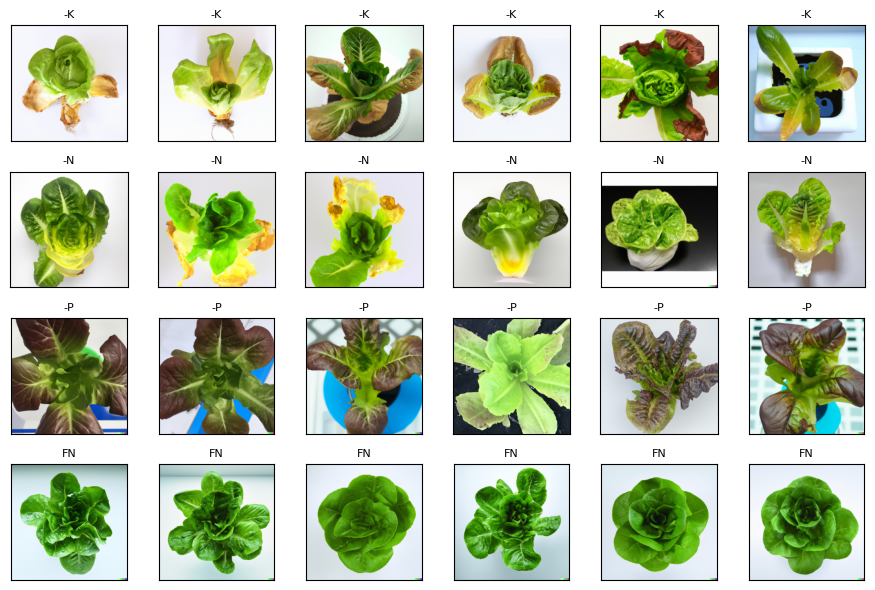

In [3]:
# Get class names and skip non-directories (like .DS_Store)
class_names = [name for name in sorted(os.listdir(image_directory)) 
               if os.path.isdir(os.path.join(image_directory, name))]

nrows = len(class_names)
ncols = 6

plt.figure(figsize=(ncols * 1.5, nrows * 1.5))

# Loop through class folders and images
for row in range(nrows):
    class_name = class_names[row]
    img_paths = [os.path.join(image_directory, class_name, filename)
                 for filename in os.listdir(os.path.join(image_directory, class_name))
                 if not filename.startswith('.')]  # Skip hidden files

    for col in range(min(ncols, len(img_paths))):  # Ensure no index error
        plt.subplot(nrows, ncols, row * ncols + col + 1)
        img = plt.imread(img_paths[col])
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(class_name, fontsize=8)

plt.tight_layout()
plt.show()

# Class Labels
- **-K:** 0 
- **-N:** 1  
- **-P:** 2  
- **FN:** 3 

In [4]:
# Load Data
dataset = datasets.ImageFolder(image_directory)        # Creates class labels: FN, -N, -P, -K
print("Classes:", dataset.classes)
print("Class Labels:", [dataset.class_to_idx[c] for c in dataset.classes])
print("Number of Images:", len(dataset.imgs))
print(dataset.imgs[0])      # (Image Path, Class Label)

Classes: ['-K', '-N', '-P', 'FN']
Class Labels: [0, 1, 2, 3]
Number of Images: 208
('/Users/ethanlewis/Desktop/Lettuce NPK/FNNPK/-K/k_1.png', 0)


# Class Distribution

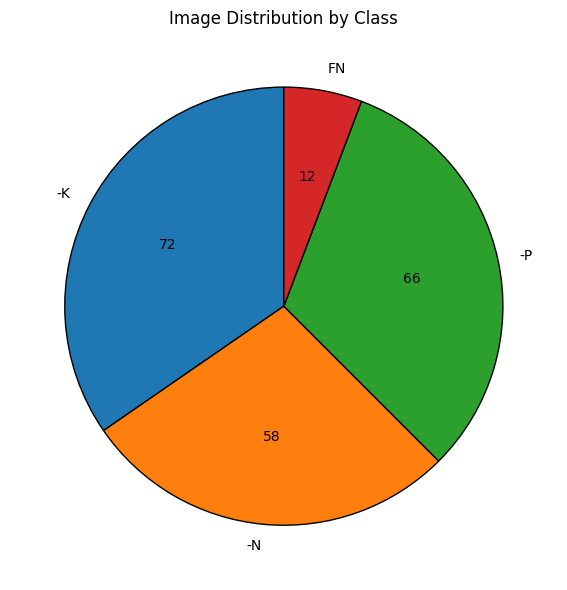

In [5]:
# Calculate the number of images per class
class_counts = {class_name: len(os.listdir(os.path.join(image_directory, class_name))) 
                for class_name in dataset.classes}

# Function to display the counts instead of percentages
def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{count}'
    return inner_autopct

# Create the Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(
    class_counts.values(), 
    labels=class_counts.keys(), 
    autopct=autopct_format(class_counts.values()), 
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Image Distribution by Class')
plt.tight_layout()
plt.show()

# Module 3 Camera Sample Image

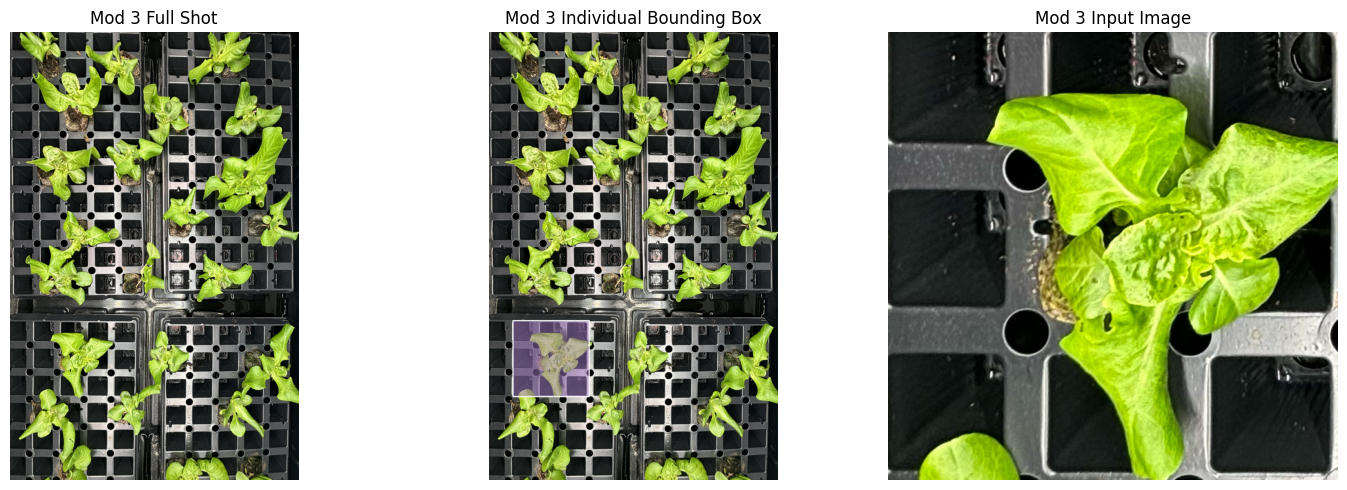

In [6]:
# Load your images
mod3_full = Image.open("/Users/ethanlewis/Desktop/Arduino Pics/Module 3 Full.jpg")
mod3_box = Image.open("/Users/ethanlewis/Desktop/Arduino Pics/Individual Bounding Box.jpg")
mod3 = Image.open("/Users/ethanlewis/Desktop/Arduino Pics/Module 3 Pic.jpg")

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figure size as needed

# Display each image in its respective subplot
images = [mod3_full, mod3_box, mod3]
titles = ["Mod 3 Full Shot", "Mod 3 Individual Bounding Box", "Mod 3 Input Image"]

for i, ax in enumerate(axes):
    ax.imshow(np.asarray(images[i]))  # Convert to NumPy array for display
    ax.set_title(titles[i], fontsize=12)  # Add title
    ax.axis('off')  # Remove axes ticks

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [7]:
mod3.size

(652, 649)

- The raw input image in our application will ultimately be 652 x 649 pixels. 
- Keep this in mind when applying transformations to training set to mimic realistic conditions of application.

# Transformation Pipeline Development

There are several key differences between the Lettuce NPK dataset images and the images the unit camera will ultimately caprture and use as input in our application. I intend to account for/ minimize these differences through a series of unique transformations...

#### **Image Backgrounds**

The majority of images in the NPK dataset feature a vivid white or black background. We know the background of our Mod3 images are mostly black (however there are several light and depth variations). 

I would like to converge all image backgrounds to some neutral and realistic RGB value to bring sole focus to the lettuce leaves in frame...

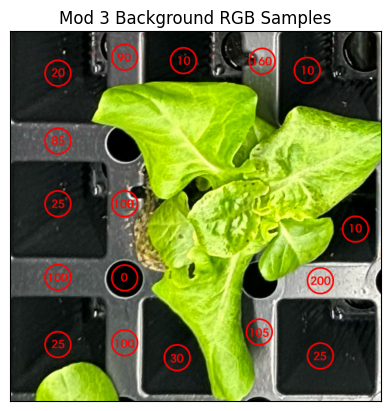

In [8]:
mod3_background = Image.open("/Users/ethanlewis/Desktop/Arduino Pics/Module 3 Background.jpg")
plt.imshow(np.asarray(mod3_background))
plt.xticks([])
plt.yticks([])
plt.title("Mod 3 Background RGB Samples")
plt.show()

Using Photoshop, I sampled 17 regions of our Mod3 image background to identify their RGB values. The average of these 17 samples was 64, so I will look to convert any near-white or black pixel values in every image to 64 (dark grey).

The following function converts all pixel values in an image > 160 (extreme white) and < 30 (extreme black) to our neutral value of 64...

In [9]:
# Custom class to convert near-white pixels to black and near-black pixels to [64, 64, 64]
class ConvertWhiteAndBlackPixels:
    def __call__(self, img):
        # Ensure the image is in RGB mode
        img = img.convert("RGB")

        # Convert the image to a NumPy array for pixel manipulation
        img_array = np.array(img)

        # Define thresholds
        white_threshold = 160  # Pixels above this threshold in all channels are considered near-white
        black_threshold = 30   # Pixels below this threshold in all channels are considered near-black

        # Create masks
        white_mask = (img_array >= white_threshold).all(axis=-1)  # Near-white mask
        black_mask = (img_array <= black_threshold).all(axis=-1)  # Near-black mask

        # Apply transformations
        img_array[white_mask] = [64, 64, 64]      # Set near-white pixels to black
        img_array[black_mask] = [64, 64, 64]   # Set near-black pixels to [64, 64, 64]

        # Convert the modified array back to a PIL image
        return Image.fromarray(img_array)

#### **Color**

A quick visual inspection the NPK dataset images and their corresponding class labels leads me to believe the distinctive coloring on the lettuce leaves may be extremley indicative of which nutrient deficiency category the plant falls into. With this in mind I would like to slightly increase the contrast and saturation of each image to really pronounce these color variations. 

**It is important to keep in mind we do not want to alter the 64RGB background pixels created by the previous function**

The following function randomly increases the image's contrast and saturation levels by up to 20%, but it *does not* apply this transformation to any pixels inside the image with an RGB value of 64.

In [10]:
# Custom function to only increase ColorJitter parameters 
def positive_color_jitter(img):
    """Apply only positive increases to brightness, contrast, saturation, and hue."""
    # Define fixed increase factors
    contrast_factor = 1 + random.uniform(0, 0.2)    # Contrast: 0-20% increase
    saturation_factor = 1 + random.uniform(0, 0.2)  # Saturation: 0-20% increase

    # Apply transformations one by one
    img = transforms.functional.adjust_contrast(img, contrast_factor)
    img = transforms.functional.adjust_saturation(img, saturation_factor)

    return img


# New function to apply jitter only to non-black (lettuce) pixels
def apply_jitter_to_leaves(img):
    """Apply color jitter only to non-black pixels."""
    # Convert image to numpy array
    img_np = np.array(img)

    # Create a mask for non-black pixels (i.e., lettuce pixels)
    mask = np.any(img_np != [64, 64, 64], axis=-1)

    # Apply jitter to the entire image
    jittered_img = positive_color_jitter(img)

    # Replace only non-black pixels with the jittered version
    img_np[mask] = np.array(jittered_img)[mask]

    # Convert back to PIL image
    return Image.fromarray(img_np)

#### **Image Size**

All images in the NPK dataset are roughly sized 1024x1000 pixels, while the input image in our application is only sized 652x649 pixels. An obvious first step is to resize all NPK images to these dimensions to arrive at a realistic input image starting point. 

Additionally, the ResNet50 backbone recommends resizing input images to 255 pixels (short side), so I will also perform this transformation. It is not clear to me whether there is any tangible difference between first resizing to 652x649 and then to 255 rather than directly resizing to 255. Given I want to simulate the most realistic input image possible, I will sequentially perform both of these resizings to the NPK images.

#### **Perspective**

It is clear all images in the NPK dataset were individually captured from a top-down perspective; this is not the case for our Mod3 images. While the Mod3 camera certianly provides an aerial view, it is mounted over a tray of 25 lettuce plants, meaning some of the plants on the edges of the frame may have a slightly skewed perspective. 

Accounting for this can easily be achieved by applying a minimal, RandomPerspective() shift to the NPK images. 

#### **Crop**

We know ResNet50 ultimately requires a 224x224 pixel input image. As we previosuly discussed, the NPK images have the luxury of being uniformly captured from the top-down, and can simply perform a CenterCrop() to create images with lettuce plants in the dead center of the image frame. 

Simply looking at our full boudnign box layout below, it is clear not all of the Mod3 images will perfectly center the plants in frame.

To simulate this effect, we can perform a RandomCrop() instead to force some of the training images to have their plants shifted from the center of the frame. 

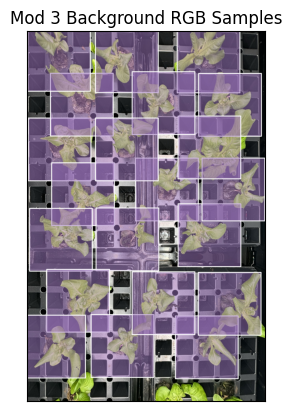

In [11]:
mod3_boxes = Image.open("/Users/ethanlewis/Desktop/Arduino Pics/Full Bounding Box Layout.jpg")
plt.imshow(np.asarray(mod3_boxes))
plt.xticks([])
plt.yticks([])
plt.title("Mod 3 Background RGB Samples")
plt.show()

# Visualize Transformations

### *Lettuce NPK Dataset* Transformation Pipeline and Sample Image

In [12]:
# Transformation Pipeline
transform = transforms.Compose([ConvertWhiteAndBlackPixels(),                                           # Convert background to neutral, 64RGB
                                transforms.Resize((652,649), antialias=True),                           # Resize image to Mod3 input image size
                                transforms.Resize(255, antialias=True),                                 # Resize image based on ResNet-50 recommendation
                                transforms.RandomPerspective(distortion_scale=0.25, p=0.5, fill=64),    # Perform random perspective shift, fill disiplaced pixels with 64RGB
                                transforms.RandomCrop(224),                                             # Randomly crop to 224x224 pixel image 
                                apply_jitter_to_leaves,                                                 # Adjust color levels of the plant
                                transforms.ToTensor(),                                                  # Convert to Tensor object
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])   # ResNet-50 pixel normalization                                                

# Load Data
dataset = datasets.ImageFolder(image_directory, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


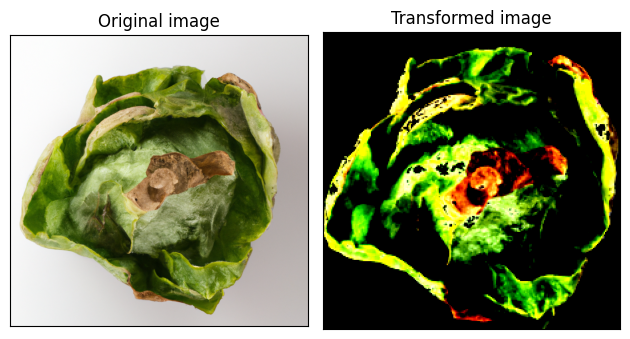

In [13]:
img_path, label = dataset.imgs[2]
original_img = Image.open(img_path)
transformed_img = transform(original_img)
imgs = [original_img, transformed_img]

plt.subplot(1, 2, 1)
plt.imshow(np.asarray(original_img))
plt.xticks([])
plt.yticks([])
plt.title("Original image")
plt.subplot(1, 2, 2)
transformed_img = torch.moveaxis(transformed_img, 0, -1) # change shape from (3, 224, 224) to (224, 224, 3)
plt.imshow(np.asarray(transformed_img))
plt.xticks([])
plt.yticks([])
plt.title("Transformed image")
plt.tight_layout()
plt.show()

### Mod3 Image Transformation Pipeline and Sample Image

In [14]:
# Ubiquitous Image Transformations
transform3 = transforms.Compose([ConvertWhiteAndBlackPixels(),                  # Convert white background to black to mimic unit environment
                                transforms.Resize((224,224), antialias=True),   # Resize to 224x224 pixel requirement (ResNet50)
                                apply_jitter_to_leaves,
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])   # Convert to Tensor object (normalized pixel values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


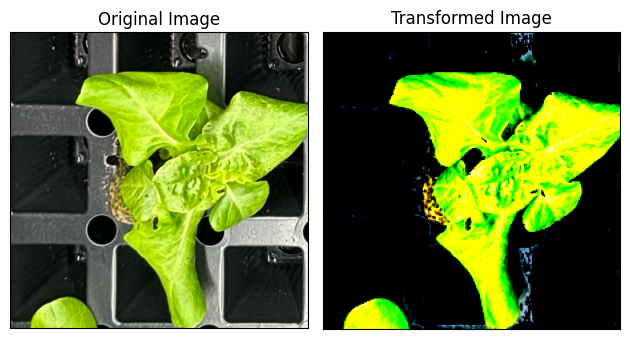

In [15]:
original_img = mod3
transformed_img = transform3(original_img)
imgs = [original_img, transformed_img]

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(np.asarray(original_img))
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.subplot(1, 2, 2)

# Transformed Image
transformed_img = torch.moveaxis(transformed_img, 0, -1)        # Convert Tensor object format to Matplotlib compatability (3,224,224) -> (224,224,3)
plt.imshow(np.asarray(transformed_img))
plt.xticks([])
plt.yticks([])
plt.title("Transformed Image")
plt.tight_layout()
plt.show()

## Summary

Visualily comparing the results of our transformations on the NPK images to the anticipated (application) appearance of our Mod3 image, it seems we have acheived a reasonable level of similarity between the images originating from two distinct sources. This should serve as a good framework to ultimately train on the NPK dataset and easily apply transfer learning to our own application. 